In [1]:
import os
import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

# Weekly Reanalysis Data - Main (reshape `xarray`)



Using the `xarray` library, let's analyze the reanalysis product

In [2]:
ds_grib = xr.load_dataset('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib', 
                          engine='cfgrib')
ds_grib

<xarray.Dataset>
Dimensions:     (time: 736, values: 542080)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... 280.0 300.0 320.0 340.0
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
Dimensions without coordinates: values
Data variables:
    t2m         (time, values) float32 247.30748 247.49889 ... 225.18036
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-27T17:12:23 GRIB to CDM+CF via cfgrib-0....

The GRIB file comes with a weird indexing, we have to change the numpy data array to represent position and time indexes: time, longitude, latitude. For this purpose, we need to change the index manually and reshape the data

In [3]:
index = pd.MultiIndex.from_arrays(
    [ds_grib.longitude.values, 
     ds_grib.latitude.values], 
    names=['lon', 'lat']
)
ds_grib['values'] = index
ds_grib_reshaped = ds_grib.unstack('values')

In [4]:
ds_grib_reshaped

<xarray.Dataset>
Dimensions:     (lat: 640, lon: 11942, time: 736)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
    step        timedelta64[ns] 00:00:00
    surface     int64 0
    latitude    (lon, lat) float64 -89.78 -89.51 -89.23 -88.95 ... nan nan nan
    longitude   (lon, lat) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    valid_time  (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
  * lon         (lon) float64 0.0 0.2812 0.2963 0.3 ... 359.7 359.7 359.7 359.7
  * lat         (lat) float64 -89.78 -89.51 -89.23 -88.95 ... 89.23 89.51 89.78
Data variables:
    t2m         (time, lon, lat) float32 241.62193 241.77232 ... nan nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-01-27T17:12:23 GRIB to CDM+CF via cfgrib-0....

Let's reshape the datafile just to get nice (and readable) plots. 

In [5]:
air = ds_grib_reshaped.t2m.T

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/dataarray.py:1897: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


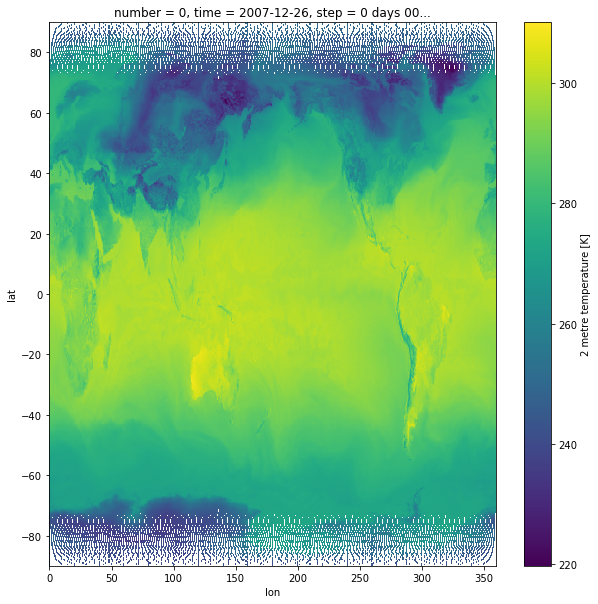

In [6]:
fig, ax = plt.subplots(figsize = (10, 10))
air.isel(time=200).plot()

Since we're interested in the weekly average changes during winter, we need to resample from daily/hourly to weekly

In [6]:
air_week = air.resample(time='1W').reduce(np.nanmean)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/resample.py:176: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  super().__init__(*args, **kwargs)
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/xarray/core/variable.py:1529: RuntimeWarning: Mean of empty slice
  data = func(input_data, axis=axis, **kwargs)


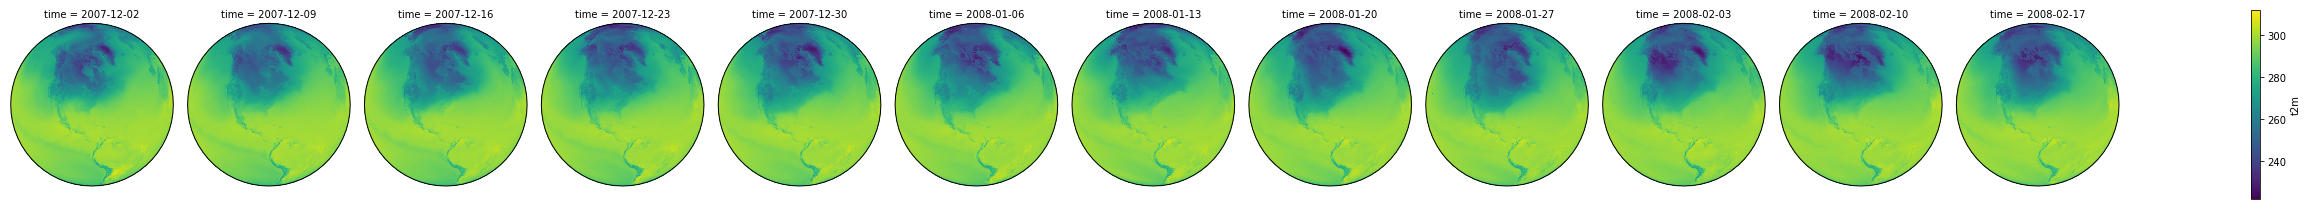

In [51]:
air_week.isel(time=range(0,len(air_week.time.data)-2)).plot(transform=ccrs.PlateCarree(), 
                                                            col='time',
                                                            subplot_kws={'projection': ccrs.Orthographic(-80, 35)})

### Pandas transformation and _fancy_ area calculation

In [25]:
def fancy_area(lat_array): 
    '''
    Calculate areas using science instead of g'old brute force
    
    :param lat_arrays np.array: Numpy or panda.Series of latitudes
    
    :returns: Area array in kilometers
    '''
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    # Fancy calulation
    lat_array_radians = lat_array * (np.pi/180)
    areas = (R_earth*dphi)**2 * np.cos(lat_array_radians)
    
    return areas

In [ ]:
# Transform xarray array to data.frame
air_week_df = air_week.to_dataframe()

# Drop undesireable columns and calculate *fancy* area
air_week_df = air_week_df.reset_index(drop=False).\
filter(['lat', 'lon', 'time', 't2m'])
air_week_df['area_grid'] = air_week_df.lat.apply(lambda x: fancy_area(x))

### Create temperature bins (each 5° K) and create cut-offs in data.frame

In [27]:
cut_off = list(range(int(min(air_week_df.t2m)), 
           int(max(air_week_df.t2m)),
           5))


###  Count weekly number of grids per temperature bucket in the northern hemisphere [$latitude > 20$]

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


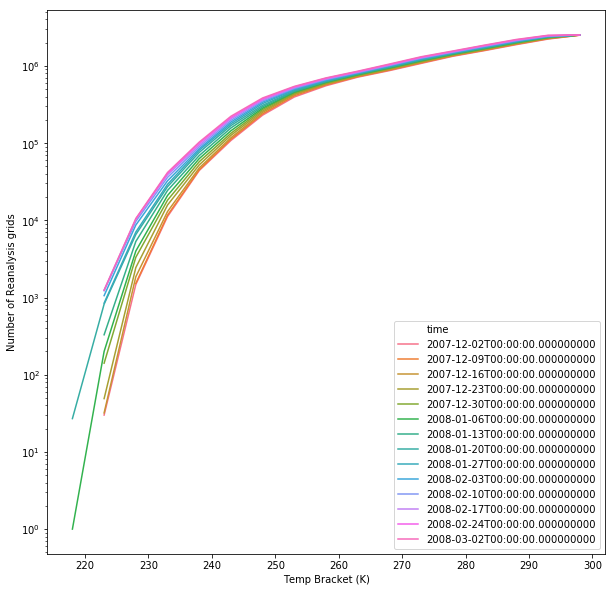

In [28]:
air_week_df = air_week_df.assign(temp_bracket =  pd.cut(air_week_df['t2m'], cut_off))
air_week_df_north = air_week_df[air_week_df.lat > 20]
air_week_df_group_north_pdf = air_week_df_north.groupby(['temp_bracket', 'time'], as_index=False)['lat'].count()

# Calculate cumulative number of grids per temperature bins
air_week_df_group_north_cdf = air_week_df_group_north_pdf.assign(lat_cumsum = air_week_df_group_north_pdf.lat.cumsum())
air_week_df_group_north_cdf['left_temp_interval']  = air_week_df_group_north_cdf.temp_bracket.apply(lambda x: x.left)

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="lat_cumsum", 
             hue='time', 
             data=air_week_df_group_north_cdf)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')
plt.yscale('log')

###  Calculate weekly temperature bucket covered area in the northern hemisphere [$latitude > 20$]

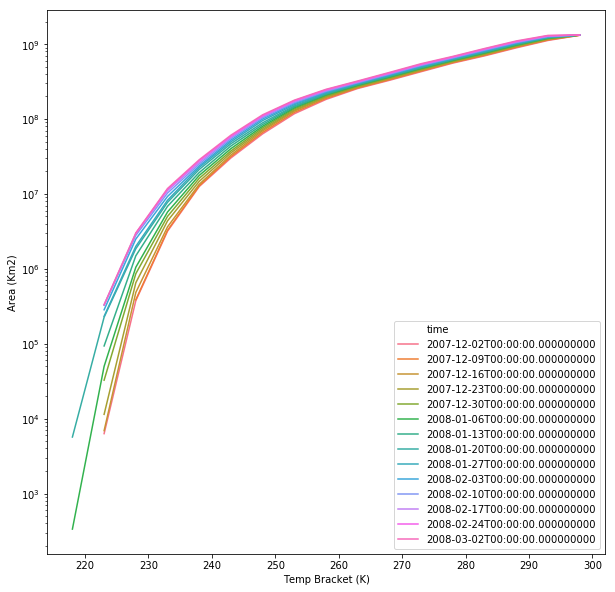

In [30]:
air_week_df = air_week_df.assign(temp_bracket =  pd.cut(air_week_df['t2m'], cut_off))
air_week_df_north = air_week_df[air_week_df.lat > 20]
air_week_df_group_north_pdf = air_week_df_north.groupby(['temp_bracket', 'time'], as_index=False)['area_grid'].sum()

# Calculate cumulative number of grids per temperature bins
air_week_df_group_north_cdf = air_week_df_group_north_pdf.assign(lat_cumsum = air_week_df_group_north_pdf['area_grid'].cumsum())
air_week_df_group_north_cdf['left_temp_interval']  = air_week_df_group_north_cdf.temp_bracket.apply(lambda x: x.left)

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="lat_cumsum", 
             hue='time', 
             data=air_week_df_group_north_cdf)
ax.set(xlabel='Temp Bracket (K)', ylabel='Area (Km2)')
plt.yscale('log')

### Calculate effective latitude using math!

We can calculate the effective $(\varphi)$ latitude using the following formula:
$$
Area = 2 \pi r (1 - sin( \varphi) )
$$

From this we can rearange the equation to get: 

$$
1 - \frac{A}{2\pi r^{2}} = arcsin(\varphi)
$$

In [37]:
def eff_latitude(area_accum_array):
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    
    pdf_lat_effs = np.pi/2.-np.arccos(1 - area_accum_array / (2 * np.pi * R_earth ** 2))
    
    return pdf_lat_effs

[Text(0,0.5,'Effective Latitude [$\\varphi$] (degrees)'),
 Text(0.5,0,'Temp Bracket (K)')]

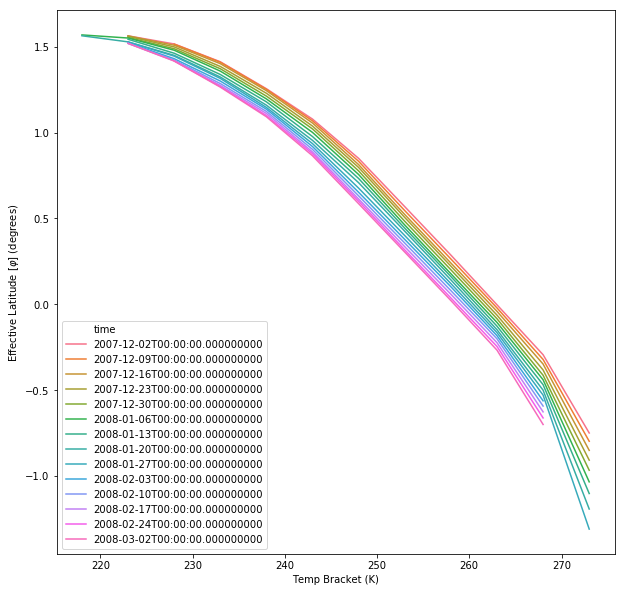

In [54]:
air_week_df_group_north_cdf['eff_latitude'] = air_week_df_group_north_cdf['lat_cumsum'].\
apply(lambda x: eff_latitude(x))

fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="eff_latitude", 
             hue='time', 
             data=air_week_df_group_north_cdf)
ax.set(xlabel="Temp Bracket (K)", ylabel=r'Effective Latitude [$\varphi$] (degrees)')

# Efficiency test: How more faster is Dask? 


Using the surface temperature data from the ERA-5 European Reanalysis, we can to calculate the surface temperatures means for the northern hemishpere for a dummy winter (Dec 2007 to Mar 2008). 


In [3]:
era_5_sfc_temp = iris.load('../cdsapi_requested_files/adaptor.mars.external-1579561890.771786-7623-33-477f8046-dadc-4922-9f24-ef068afe5647.grib')
era_5_sfc_temp_array = xr.DataArray.from_iris(era_5_sfc_temp[0])

In [4]:
era_5_sfc_temp_array.data

,Array,Chunk
Bytes,3.19 GB,4.34 MB
Shape,"(736, 542080)","(1, 542080)"
Count,2944 Tasks,736 Chunks
Type,float64,numpy.ndarray


In [6]:
era_5_sfc_temp_array

<xarray.DataArray 'air_temperature' (time: 736, dim_1: 542080)>
dask.array<filled, shape=(736, 542080), dtype=float64, chunksize=(1, 542080), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 2007-12-01 ... 2008-03-01T21:00:00
    forecast_period     timedelta64[ns] ...
    height              int64 ...
    originating_centre  <U50 ...
    latitude            (dim_1) float64 ...
    longitude           (dim_1) float64 ...
Dimensions without coordinates: dim_1
Attributes:
    standard_name:  air_temperature
    long_name:      air_temperature
    units:          K